In [ ]:
#|default_exp speckles

# Speckles 

> Annoying and interesting paper inclusions 

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2 

In [ ]:
#|hide 
import os

In [ ]:
#|hide
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#|code-fold: true 

import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import skimage.exposure as ske
import skimage.measure as skm
import skimage.morphology as smo

from maxrf4u import DataStack

Historic handmade papers can contain various types of metal inclusions. Iron and manganese can be abundantly present in groundwater and are notoriously difficult to remove. Hence, historic papers typically contain iron/manganese inclusions. Another source of metal inclusions is the wear of paper making equipment such as the brass wires of a paper making mold. 

These metal inclusions in paper lead to spikes in the elemental maps computed from MA-XRF data. If one is interested in the distribution of elements due to media like ink, such spikes are annoying and need to be filtered out of the elemental maps. We will develop code here to do so. On the other hand, the composition and distribution of metal inclusions in paper is an interesting new source of information that might reveal details of the paper making process and help to distinguish different papers.  

Automated detection of speckles can be hard if one encounters situations where the presence of a certain element is due to multiple materials present in the drawing. For the Suzanna drawing his is for example the case with zinc, which is an element present in brass (Cu + Zn) particles and also occurs as an element in the white vitriol (ZnSO4) that seems to be used in the gelatin sizing of the paper. 

**A systematic approach would be a multi channel segmentation of the stack of element maps. However for now I do not have time to work on this. So let's just explore in an ad-hoc fashion the copper and iron inclusions that we encounter...**

## Brass inclusions 

The trouble with speckles is that often they are too small to be directly noticed in an element map without zooming in. Although single pixel can be bright, it doesn't show up in a full element map plot at limited resolution. Some bright speckles can be made visible with a Gaussian blur filter. 

To explore the presence of brass particles we need to look at copper and zinc...

Let's load image of the drawing as well as the element maps of copper, zinc and sulfur into memory. 

In [ ]:
#|code-fold: true 

ds = DataStack('RP-T-1898-A-3689.datastack') 
extent = ds.read('imvis_extent')
imvis = ds.read('imvis_reg_highres')

elements = ds.read('nmf_elements')
element_maps = ds.read('nmf_elementmaps')
element_maps_dict = dict(zip(elements, element_maps))

Cu_map = element_maps_dict['Cu']
Zn_map = element_maps_dict['Zn']
S_map = element_maps_dict['S']

Cu_map_norm = Cu_map / Cu_map.max()
Zn_map_norm = Zn_map / Zn_map.max()
S_map_norm = S_map / S_map.max()

Let's plot the Gaussian blurred maps next to the high-res image. 

In [ ]:
#|code-fold: true 
import skimage.filters as skf

In [ ]:
#|code-fold: true 

Cu_map_gauss = skf.gaussian(Cu_map, sigma=5)
Zn_map_gauss = skf.gaussian(Zn_map, sigma=5)
S_map_gauss = skf.gaussian(S_map, sigma=5)

<IPython.core.display.Javascript object>


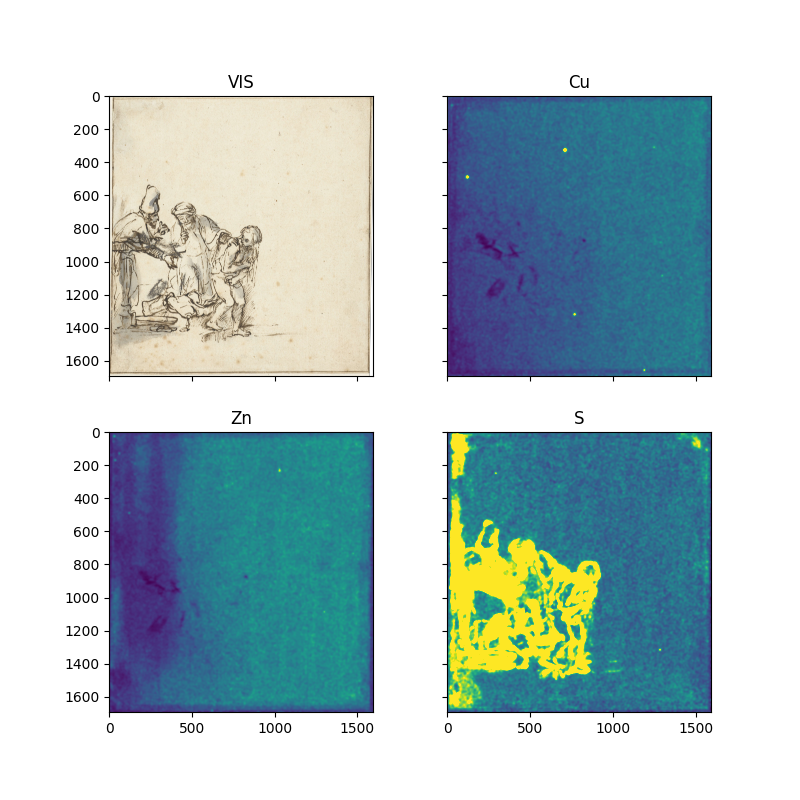

In [ ]:
#|code-fold: true 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8], sharex=True, sharey=True)

axs = axs.flatten()

axs[0].imshow(imvis, extent=extent)
axs[1].imshow(Cu_map_gauss, vmax=0.4)
axs[2].imshow(Zn_map_gauss)
axs[3].imshow(S_map_gauss, vmax=0.06);

for i, t in enumerate(['VIS', 'Cu', 'Zn', 'S']): 
    axs[i].set_title(t)
    
plt.subplots_adjust()

Several observations can me made from these Gaussian blurred and intensity clipped element maps: 

(1) Our best possibility to locate brass particles for this specific drawing is the copper map. Although we do find a non-zero copper signal in the paper background of this drawing, it is of lower intensity then the particles. We are lucky here. Other drawings often do contain copper as a constituent of the ink. Altogether we can locate four copper containing particles.  

(2) With respect to zinc we see that the larger part of the paper background contains zinc, likely due to the gelatin sizing of the paper containing zinc-sulfate. Against this background is difficult to directly extract the zinc signal due to the brass particles. Instead we need to zoom in to the copper regions and check if they correlate with zinc. Additionally we do find a single high concentration of zinc without copper in the upper part of the zinc map at xy=(1029, 231). 

(3) Although one would expect sulfur to correlate with zinc sulphate present in the sizing, the sulfur map does not show this correlation. Probably the low intensity sulfur signal due to the zinc-sulfate can not be separated from the elastic scattering of the background. 

<IPython.core.display.Javascript object>


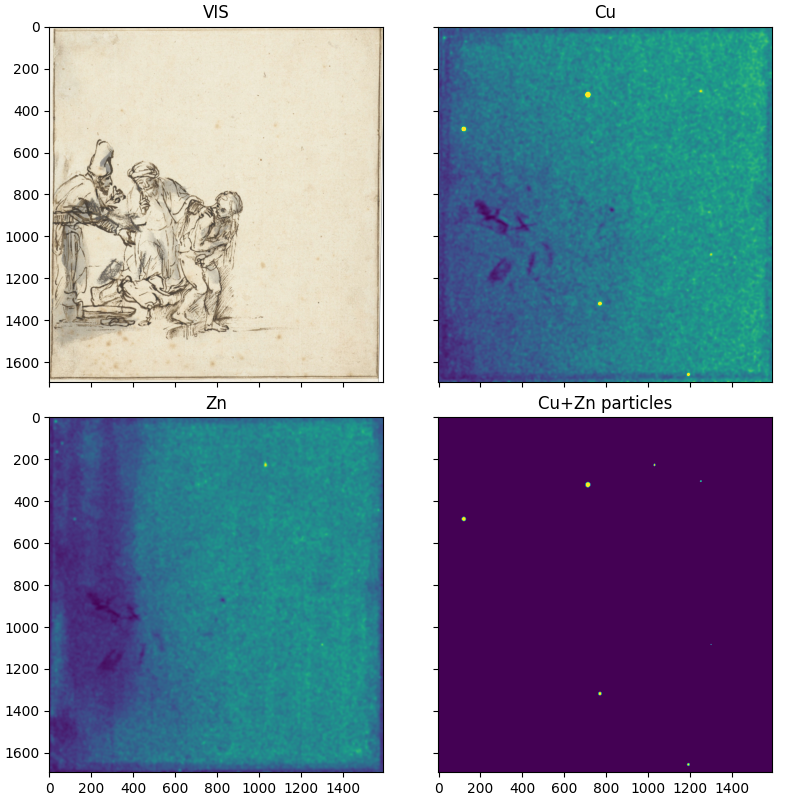

In [ ]:
#|code-fold: true 

Cu_clip = Cu_map_gauss > 0.28 
Zn_clip = Zn_map_gauss > 0.7
Cu_Zn_mask = Cu_clip + Zn_clip

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8], sharex=True, sharey=True, constrained_layout=True)

axs = axs.flatten()

axs[0].imshow(imvis, extent=extent)
axs[1].imshow(Cu_map_gauss, vmax=0.3)
axs[2].imshow(Zn_map_gauss)
axs[3].imshow(Cu_Zn_mask);

for i, t in enumerate(['VIS', 'Cu', 'Zn', 'Cu+Zn particles']): 
    axs[i].set_title(t)
    


We can now use the copper plus zinc particles mask to mark all individual particles using the `skimage.measure.label()` function.

In [ ]:
#|code-fold: true 

labeled_image = skm.label(Cu_Zn_mask)
n_particles = labeled_image.max()
n_particles

7

We have found 7 particles. Let's add circle markers to the plot above.  

In [ ]:
#|code-fold: true 

colors = cm.tab20(range(n_particles))

props = skm.regionprops_table(labeled_image, properties=['centroid'])
cy = props['centroid-0']
cx = props['centroid-1']

axs[3].scatter(cx, cy, marker='s', s=80, facecolors='none', edgecolors=colors)
for i in range(n_particles):
    axs[3].text(cx[i]-30, cy[i]-60, i+1, color=colors[i])

Now let's create an overview plot with all particles zoomed in. 

<IPython.core.display.Javascript object>


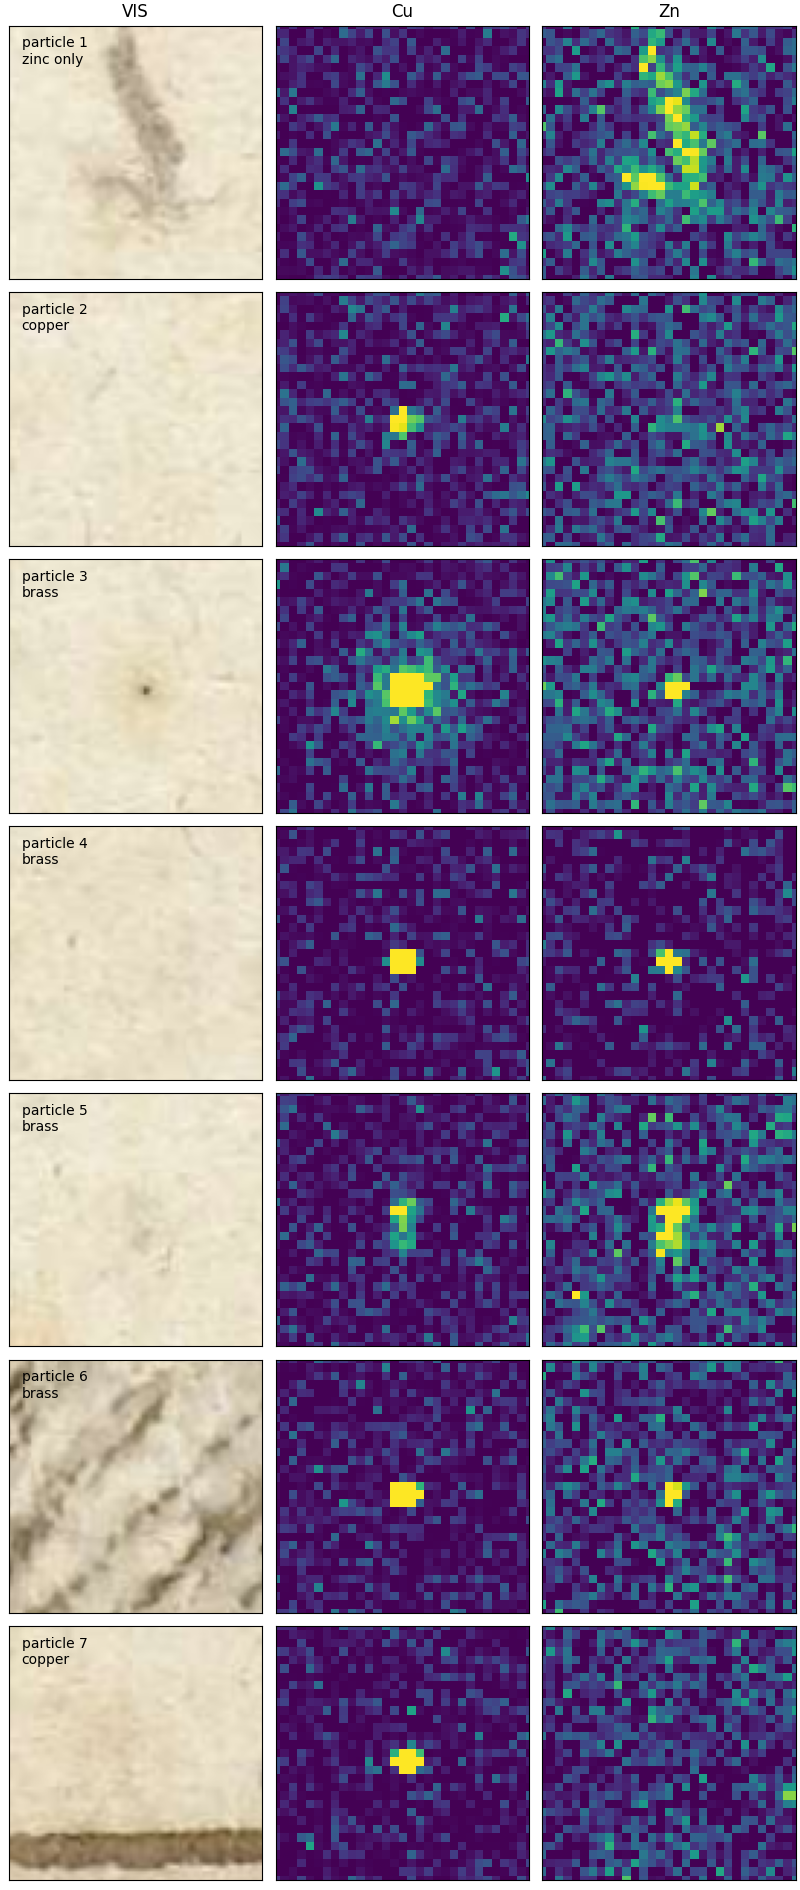

In [ ]:
#|code-fold: true 

h = 15 # half height 

xlim_list = []
ylim_list = []

for i, [xi, yi] in enumerate(zip(cx, cy)): 
    
    xlim = [int(xi) - h, int(xi) + h]
    xlim_list.append(xlim)
    
    ylim = [int(yi) + h, int(yi) - h]
    ylim_list.append(ylim) 

labels = ['particle 1\nzinc only', 'particle 2\ncopper', 'particle 3\nbrass', 'particle 4\nbrass', 
          'particle 5\nbrass', 'particle 6\nbrass', 'particle 7\ncopper']

fig, axs = plt.subplots(nrows=n_particles, ncols=3, figsize=[8, n_particles*2.7], constrained_layout=True)

    
for i, [xlim, ylim] in enumerate(zip(xlim_list, ylim_list)): 

    axs[i, 0].imshow(imvis, extent=extent)
    axs[i, 0].set_xlim(xlim)
    axs[i, 0].set_ylim(ylim)
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].text(0.05, 0.85, labels[i], transform=axs[i, 0].transAxes)
    #axs[i, 0].set_ylabel('hi')
    
    axs[i, 1].imshow(Cu_map, vmax=2)
    axs[i, 1].set_xlim(xlim)
    axs[i, 1].set_ylim(ylim)
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
       
    axs[i, 2].imshow(Zn_map, vmax=2)
    axs[i, 2].set_xlim(xlim)
    axs[i, 2].set_ylim(ylim)
    axs[i, 2].set_ylim(ylim)
    axs[i, 2].set_xticks([])
    axs[i, 2].set_yticks([])

axs[0,0].set_title('VIS')
axs[0,1].set_title('Cu')
axs[0,2].set_title('Zn');
        

Following the ad-hoc method described above, we find five brass particles, two copper particles and one brown fiber inclusion with zinc only. 

In [ ]:
#| hide 

class SpeckleAtlas(): 
    
    def __init__(self, peak_map, n_heights=100): 
        
        
        self.peak_map = peak_map 
        
        h, w = self.peak_map.shape
        self.n_px =  h * w 
        
        self.heights = np.linspace(peak_map.min(), peak_map.max(), n_heights)
        
        # perhaps better just iterate 
        height_maps = [self.peak_map > h for h in self.heights] 

        largest_area_list = [] 
        largest_label_list = []
        n_regions_list = []

        for i, hm in enumerate(height_maps): 

            print(f'Inspecting height slice: {i}/{n_heights}', end='\r')

            label_image = skm.label(height_maps[i].astype(int), connectivity=1)
            props = skm.regionprops(label_image)
            n_regions_list.append(len(props))
            areas_labels = np.array([[p.area, p.label] for p in props])

            label_image = skm.label(height_maps[i], connectivity=1)

            props = skm.regionprops(label_image)

            areas_labels = np.array([[p.area, p.label] for p in props])

            # in case of zero regions:  
            if len(areas_labels) == 0: 
                areas_labels = np.array([[0, 0]])

            areas, labels = areas_labels.T

            largest_area_i = np.argmax(areas)
            largest_area = areas[largest_area_i]
            largest_label = labels[largest_area_i]

            largest_area_list.append(largest_area)
            largest_label_list.append(largest_label) 
                
        
        self.largest_areas = largest_area_list   
        self.largest_labels = largest_label_list 
        self.n_regions = n_regions_list 

        
    def measure_speckles(self, max_area=100): 
        '''Find, sort, label and measure speckle regions.  
        
        Selects lowest height slice with all speckle regions smaller then *max_area*. 
        
        Returns: *clip_height* '''
        
        # find largest speckle and associated clip height 
        self.max_area = max_area 
        self.clip_height_i = np.argmin((np.array(self.largest_areas) - max_area)**2) 
        self.clip_height = self.heights[self.clip_height_i] 
        self.largest_speckle_label = self.largest_labels[self.clip_height_i] 
        
        # unsorted label image for clip level  
        unsorted_label_image = skm.label(self.peak_map > self.clip_height)
        uprops = skm.regionprops(unsorted_label_image) 

        u_areas = np.array([p.area for p in uprops])
        u_labels = np.array([p.label for p in uprops]) # [1, 2, 3 ...]

        # create area sorted labels 
        indices = np.argsort(u_areas)[::-1]
        area_sorted_labels = u_labels[indices]

        #prepend zero index for background 
        area_sorted_labels_bg = np.r_[0, area_sorted_labels]
        
        # make relabel lut 
        n_labels = len(area_sorted_labels_bg)
        relabel_lut = np.zeros(n_labels, dtype=int)
        
        # say region with label 123 is largest speckle 
        # then lut[123] = 1 
        relabel_lut[area_sorted_labels_bg] = np.arange(n_labels)
        
        # took me quite some time to debug so let's make sure next time 
        assert relabel_lut[area_sorted_labels_bg[1]] == 1, 'Relabeling of image went wrong' 
        
        self.relabel_image = relabel_lut[unsorted_label_image] 
        
        # determine region props 
        self.props = skm.regionprops(self.relabel_image, intensity_image=self.peak_map)
        
        self.centroids_y, self.centroids_x = np.array([p.centroid for p in self.props]).T
        self.centroids_xy = np.c_[self.centroids_x, self.centroids_y]
                                  
        return self.clip_height 
    
    
    def speckle_spectrum(self, arr, speckle_i): 
        '''Get averaged speckle spectrum for region of *speckle_i*. 
        
        Returns: *spectrum*
        -------
        '''

        print(speckle_i, end='\r')

        p = self.props[speckle_i]
        
        spectrum = region_spectra(arr, mask=p.image, average=True)
               
        return spectrum 
    